# Experiment

## Install Python dependencies

In [1]:
!pip install onnx==1.12.0 \
        onnxruntime==1.16.1 \
        seaborn==0.13.0 \
        tf2onnx==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 153.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 323.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 235.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 212.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 256.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 321.9 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Import the dependencies for the model training code:

In [3]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [4]:
Data = pd.read_csv('data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

X = Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud'])
y = Data['fraud']

# Split the data into training and testing sets so you have something to test the trained model with.

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [8]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

## Train the model

In [9]:
# Train the model and get performance
import os

epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values),y_val), \
                    verbose = True, class_weight = class_weights)
print("Training of model is complete")

Epoch 1/2
20000/20000 [==============================] - 36s 2ms/step - loss: 0.2580 - accuracy: 0.9311 - val_loss: 0.2256 - val_accuracy: 0.9466
Epoch 2/2
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2351 - accuracy: 0.9485 - val_loss: 0.2063 - val_accuracy: 0.9526
Training of model is complete


## Save the model file

In [11]:
# Save the model as ONNX for easy use of ModelMesh
model_proto, _ = tf2onnx.convert.from_keras(model)
os.makedirs("models/fraud", exist_ok=True)
onnx.save(model_proto, "models/fraud/model.onnx")

## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [12]:
! ls -alRh ./models/

./models/:
total 12K
drwxr-sr-x.  3 1004090000 1004090000 4.0K Nov 14 17:29 .
drwxr-sr-x. 13 1004090000 1004090000 4.0K Nov 14 17:29 ..
drwxr-sr-x.  2 1004090000 1004090000 4.0K Nov 14 17:29 fraud

./models/fraud:
total 24K
drwxr-sr-x. 2 1004090000 1004090000 4.0K Nov 14 17:29 .
drwxr-sr-x. 3 1004090000 1004090000 4.0K Nov 14 17:29 ..
-rw-r--r--. 1 1004090000 1004090000  13K Nov 14 17:29 model.onnx


## Create a date-stamped folder

In [13]:
# Create a date-stamped folder for fraud models
current_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
fraud_folder = os.path.join("models/", current_date + "-fraud")
os.makedirs(fraud_folder, exist_ok=True)

# Save the model to the date-stamped folder
model_path = os.path.join(fraud_folder, "model.onnx")
onnx.save(model_proto, model_path)

print(f"Saved the model to {model_path}")

Saved the model to models/20231114-173006-fraud/model.onnx


Confirm that the model file was created successfully. 
The output should include the model file name, size, and date. 

In [12]:
! ls -alh ./models/

total 20K
drwxr-sr-x.  5 1014660000 1014660000 4.0K Nov 14 00:45 .
drwxr-sr-x. 13 1014660000 1014660000 4.0K Nov 14 00:43 ..
drwxr-sr-x.  2 1014660000 1014660000 4.0K Nov 14 00:36 20231114-003600-fraud
drwxr-sr-x.  2 1014660000 1014660000 4.0K Nov 14 00:45 20231114-004536-fraud
drwxr-sr-x.  2 1014660000 1014660000 4.0K Nov 14 00:33 fraud


## Test the model

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

Load the test data and scaler:

In [15]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [16]:
sess = rt.InferenceSession("models/fraud/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.995
y_pred = np.where(y_pred_temp > threshold, 1,0)

Show the results:

Accuracy: 0.96566


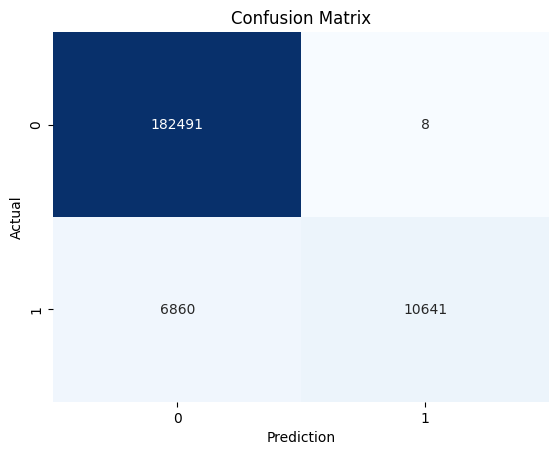

In [17]:
accuracy = np.sum(np.asarray(y_test) == y_pred) / len(y_pred)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True,fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [18]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was Sally's transaction to be fraudulent? 
0.00004%
